# 2D image transformation demo

This demo shows how to apply 2D transforms in MONAI.
Main features:
* Random elastic transforms implemented in native Pytorch
* Easy-to-use interfaces that are designed and implemented in the pythonic way

Find out more in MONAI's wiki page: https://github.com/Project-MONAI/MONAI/wiki

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/transforms_demo_2d.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow,tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
from monai.transforms import Affine, Rand2DElastic
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os

## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.6.0+135.g3cb355bb
Numpy version: 1.21.2
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 3cb355bb4e50702a17854cea1b817076c021c1b5

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.2
Tensorboard version: 2.6.0
gdown version: 3.13.0
TorchVision version: 0.10.0
tqdm version: 4.62.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.3
einops version: 0.3.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmpo87g5vor


## Download dataset

Downloads and extracts the dataset. The dataset comes from https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/.

The dataset used in this competition is provided for research purposes only. Commercial uses are not allowed.

K. Sirinukunwattana, J. P. W. Pluim, H. Chen, X Qi, P. Heng, Y. Guo, L. Wang, B. J. Matuszewski, E. Bruni, U. Sanchez, A. Böhm, O. Ronneberger, B. Ben Cheikh, D. Racoceanu, P. Kainz, M. Pfeiffer, M. Urschler, D. R. J. Snead, N. M. Rajpoot, "Gland Segmentation in Colon Histology Images: The GlaS Challenge Contest" http://arxiv.org/abs/1603.00275

K. Sirinukunwattana, D.R.J. Snead, N.M. Rajpoot, "A Stochastic Polygons Model for Glandular Structures in Colon Histology Images," in IEEE Transactions on Medical Imaging, 2015
doi: 10.1109/TMI.2015.2433900



In [5]:
resource = "https://warwick.ac.uk/fac/sci/dcs/research/tia/" \
    + "glascontest/download/warwick_qu_dataset_released_2016_07_08.zip"
md5 = None

compressed_file = os.path.join(
    root_dir, "warwick_qu_dataset_released_2016_07_08.zip")
data_dir = os.path.join(root_dir, "Warwick QU Dataset (Released 2016_07_08)")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

warwick_qu_dataset_released_2016_07_08.zip: 173MB [00:20, 8.95MB/s]                              


Downloaded: /var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmpo87g5vor/warwick_qu_dataset_released_2016_07_08.zip
Expected md5 is None, skip md5 check for file /var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmpo87g5vor/warwick_qu_dataset_released_2016_07_08.zip.
Writing into directory: /var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmpo87g5vor.


In [6]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"

In [7]:
img_name = os.path.join(data_dir, "train_22.bmp")
seg_name = os.path.join(data_dir, "train_22_anno.bmp")
im = np.array(PIL.Image.open(img_name))
seg = np.array(PIL.Image.open(seg_name))

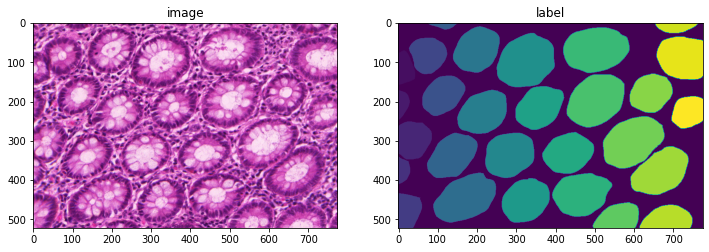

(522, 775, 3) (522, 775)


In [8]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(seg)
plt.show()
print(im.shape, seg.shape)

## Affine transformation

In [9]:
# MONAI transforms always take channel-first data: [channel x H x W]
im_data = np.moveaxis(im, -1, 0)  # make them channel first
seg_data = np.expand_dims(seg, 0)  # make a channel for the segmentation

# create an Affine transform
affine = Affine(
    rotate_params=np.pi / 4,
    scale_params=(1.2, 1.2),
    translate_params=(200, 40),
    padding_mode="zeros",
    device=device,
)
# convert both image and segmentation using different interpolation mode
new_img, _ = affine(im_data, (300, 400), mode="bilinear")
new_seg, _ = affine(seg_data, (300, 400), mode="nearest")
print(new_img.shape, new_seg.shape)

(3, 300, 400) (1, 300, 400)


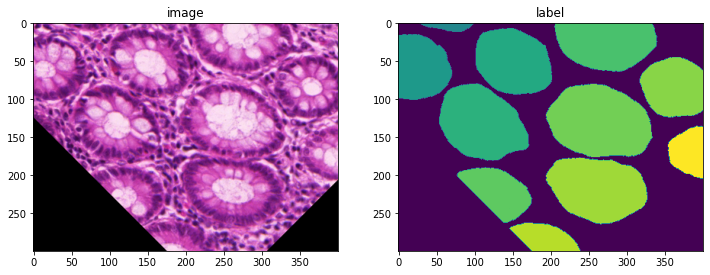

In [10]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(new_seg[0].astype(int))
plt.show()

## Elastic deformation

In [11]:
# create an elsatic deformation transform
deform = Rand2DElastic(
    prob=1.0,
    spacing=(30, 30),
    magnitude_range=(5, 6),
    rotate_range=(np.pi / 4,),
    scale_range=(0.2, 0.2),
    translate_range=(100, 100),
    padding_mode="zeros",
    device=device,
)
# transform both image and segmentation using different interpolation mode
deform.set_random_state(seed=123)
new_img = deform(im_data, (224, 224), mode="bilinear")
deform.set_random_state(seed=123)
new_seg = deform(seg_data, (224, 224), mode="nearest")
print(new_img.shape, new_seg.shape)

(3, 224, 224) (1, 224, 224)


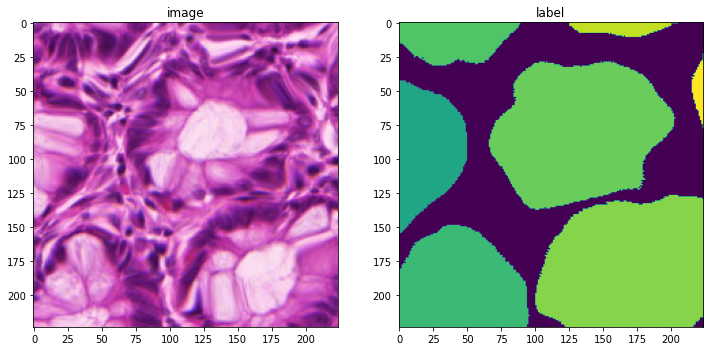

In [12]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(new_seg[0].astype(int))
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [13]:
if directory is None:
    shutil.rmtree(root_dir)